In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *

import pickle
import os

# Cleaning NBA and NCAA data

## Draft data

In [41]:
df_draft_raw = pd.read_csv("../data/draft.csv", index_col=0)

In [42]:
df_draft = (df_draft_raw
                .rename(columns={'Year': 'draft_year', 'Lg': 'league', 'Rd': 'round', 
                                         'Pk': 'pick', 'Tm': 'draft_team', 'Pos': 'position'})
                .assign(Player = lambda x: x.Player.str.split('\\').str.get(0)))
df_draft.columns = df_draft.columns.str.lower()

In [43]:
df_draft.head()

,draft_year,league,round,pick,draft_team,player,age,position,born,college
Rk,,,,,,,,,,
1,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University
2,2016,NBA,1,2,LAL,Brandon Ingram,18.299,F,us,Duke University
3,2016,NBA,1,3,BOS,Jaylen Brown,19.247,F-G,us,University of California
4,2016,NBA,1,4,PHO,Dragan Bender,18.223,F,ba,NaN
5,2016,NBA,1,5,MIN,Kris Dunn,22.103,G,us,Providence College


In [44]:
print("There are {} years, {} teams, {} players".format(len(pd.unique(df_draft.draft_year)),
                                                        len(pd.unique(df_draft.draft_team)), 
                                                        len(pd.unique(df_draft.player))))

There are 19 years, 37 teams, 1122 players


There are players who are not drafted form any college. They mostly are non-US players.

In [45]:
df_draft.loc[pd.isnull(df_draft.college), :].head()

,draft_year,league,round,pick,draft_team,player,age,position,born,college
Rk,,,,,,,,,,
4,2016,NBA,1,4,PHO,Dragan Bender,18.223,F,ba,NaN
10,2016,NBA,1,10,MIL,Thon Maker,19.123,F-C,ss,NaN
13,2016,NBA,1,13,PHO,Georgios Papagiannis,18.360,C,gr,NaN
15,2016,NBA,1,15,DEN,Juan Hernangomez,20.274,F,es,NaN
16,2016,NBA,1,16,BOS,Guerschon Yabusele,20.194,F,fr,NaN


Player names are unique, and ~60 are drafted each year. The number of colleges are different across years because some players are not drafted from college (e.g. from high school, from other countries.)

In [46]:
df_draft.groupby('draft_year')['player', 'college'].agg(['count', 'nunique'])

player         college        
            count nunique   count nunique
draft_year                               
1998           58      58      50      39
1999           58      58      51      45
2000           58      58      47      36
2001           57      57      45      35
2002           57      57      42      32
2003           58      58      33      31
2004           59      59      37      33
2005           60      60      37      32
2006           60      60      44      30
2007           60      60      47      35
2008           60      60      49      35
2009           60      60      48      35
2010           60      60      53      40
2011           60      60      46      34
2012           60      60      51      31
2013           60      60      47      40
2014           60      60      46      32
2015           60      60      46      32
2016           60      60      44      31

## NBA rookie data

In [47]:
df_nba_raw = pd.read_csv("../data/nbarookiedata.csv", skiprows=1, index_col=0)

In [48]:
df_nba = (df_nba_raw
             .assign(Player = lambda x: x.Player.str.split('\\').str.get(0),
                     Season = lambda x: pd.to_numeric(x.Season.str.split('-').str.get(0)))
             [['Player', 'Tm', 'Season', 'PTS', 'TRB', 'AST', 'STL', 'BLK']]
             .rename(columns={'Player': 'player', 'Tm': 'rookie_team', 'Season': 'rookie_year', 
                              'PTS': 'point', 'TRB': 'rebound', 'AST': 'assist',
                              'STL': 'steal', 'BLK': 'block'}))

In [49]:
df_nba.head()

,player,rookie_team,rookie_year,point,rebound,assist,steal,block
Rk,,,,,,,,
1,Alex Abrines,OKC,2016,6.0,1.3,0.6,0.5,0.1
2,Ron Baker,NYK,2016,4.1,1.9,2.1,0.7,0.2
3,Wade Baldwin,MEM,2016,3.2,1.4,1.8,0.5,0.2
4,Malik Beasley,DEN,2016,3.8,0.8,0.5,0.3,0.0
5,DeAndre' Bembry,ATL,2016,2.7,1.6,0.7,0.2,0.1


## Merge NBA draft and rookie

In [50]:
# We merge the draft and the rookie NBA data based on player name only
# NOT based on team and year, because a player can be drafted for a team in a year
# and then becomes the rookie for another team in another year (due to trade, injuries, etc.)
df_final = pd.merge(df_draft, df_nba, how='left', on=['player'])

In [51]:
# There are a lot of players drafted but don't appear in the NBA dataset
# Reasons: Injuries so never play, get moved to another league
df_final.loc[pd.isnull(df_final.point), :].shape

(278, 17)

In [52]:
# Number of missingness by year
df_final.loc[pd.isnull(df_final.point), :].groupby('draft_year')['player'].agg('count')

draft_year
1998    53
1999    51
2000     8
2001     8
2002     9
2003    11
2004    13
2005     6
2006     8
2007    11
2008    10
2009    12
2010     9
2011     6
2012     5
2013     9
2014    12
2015    19
2016    18
Name: player, dtype: int64

## NCAA performance

In [53]:
df_ncaa_raw = pd.read_csv('../data/ncaa2.csv', index_col=0)

In [54]:
df_ncaa = (df_ncaa_raw
              [['Name', 'Team', 'year', 'Pts', 'TOT', 'Asts', 'Stls', 'Blks']]
              .rename(columns={'Name': 'player', 'Team': 'college', 'year': 'col_year',
                               'Pts': 'col_point', 'TOT': 'col_rebound', 'Asts': 'col_assist',
                               'Stls': 'col_steal', 'Blks': 'col_block'}))

In [55]:
df_ncaa.head()

,player,college,col_year,col_point,col_rebound,col_assist,col_steal,col_block
0,Luis Rivas,Western Illinois,2002,27.9,10.7,0.0,0.0,0.5
1,Steve Reynolds,Western Michigan,2002,27.8,6.5,2.0,1.2,0.1
2,Michael Watson,UMKC,2002,24.9,3.6,3.2,2.1,0.2
3,Tyrone Hayes,Idaho,2002,34.3,12.3,0.0,2.5,2.5
4,Travis Robinson,Jacksonville,2002,27.4,7.5,1.1,1.9,0.3


In [56]:
df_final = pd.merge(df_final, df_ncaa, how='inner', on=['player'])

In [57]:
# Only keep the last year of college performance
df_final = (df_final.groupby('player')
        .apply(lambda df: df.sort_values(by='col_year', ascending=False).iloc[0, :]))

In [58]:
df_final.head()

,draft_year,league,round,pick,draft_team,player,age,position,born,college_x,...,assist,steal,block,college_y,col_year,col_point,col_rebound,col_assist,col_steal,col_block
player,,,,,,,,,,,,,,,,,,,,,
A.J. Hammons,2016,NBA,2,46,DAL,A.J. Hammons,23.306,C,us,Purdue University,...,0.2,0.0,0.6,Purdue,2014,16.6,11.4,0.7,0.6,4.7
A.J. Price,2009,NBA,2,52,IND,A.J. Price,22.267,G,us,University of Connecticut,...,1.9,0.6,0.1,Connecticut,2009,17.8,4.2,5.7,0.8,0.0
Aaron Brooks,2007,NBA,1,26,HOU,Aaron Brooks,22.170,G,us,University of Oregon,...,1.7,0.3,0.1,Oregon,2007,19.2,4.6,4.6,1.5,0.2
Aaron Gordon,2014,NBA,1,4,ORL,Aaron Gordon,18.288,F,us,University of Arizona,...,0.7,0.4,0.5,Arizona,2014,16.3,10.5,2.6,1.2,1.4
Aaron Gray,2007,NBA,2,49,CHI,Aaron Gray,22.208,C,us,University of Pittsburgh,...,0.7,0.3,0.3,Pittsburgh,2007,20.5,14.0,2.5,0.6,2.5


In [59]:
df_final.columns

Index(['draft_year', 'league', 'round', 'pick', 'draft_team', 'player', 'age',
       'position', 'born', 'college_x', 'rookie_team', 'rookie_year', 'point',
       'rebound', 'assist', 'steal', 'block', 'college_y', 'col_year',
       'col_point', 'col_rebound', 'col_assist', 'col_steal', 'col_block'],
      dtype='object')

In [60]:
print("Number of unique players {}, teams {}, college {}, year {}"
          .format(len(pd.unique(df_final.player)),
                  len(pd.unique(df_final.rookie_team)),
                  len(pd.unique(df_final.college_x)),
                  len(pd.unique(df_final.rookie_year))))

Number of unique players 613, teams 37, college 139, year 18


# Visualization

Players always perform much better in college than in the NBA. There is a positive relationship, but not really strong.

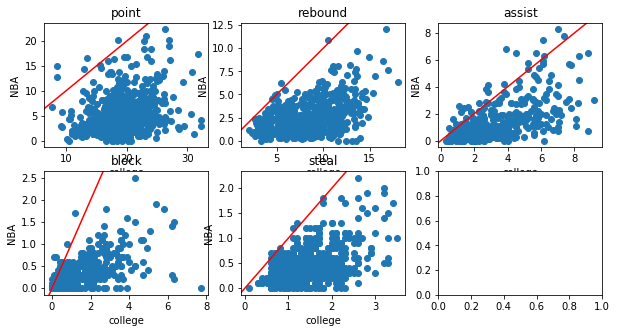

In [61]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

vars = ['point', 'rebound', 'assist', 'block', 'steal']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
for r in range(len(ax)):
    for c in range(len(ax[0])):
        i = r * 3 + c
        try:
            ax[r][c].scatter(df_final['col_' + vars[i]], df_final[vars[i]])
            add_identity(ax[r][c], color='r')
            ax[r][c].set_title(vars[i])
            ax[r][c].set_xlabel('college')
            ax[r][c].set_ylabel('NBA')
        except:
            pass

# Model building

In [62]:
print("Before shape {}".format(df_final.shape))
df_final = df_final.dropna() # Drop all missing values
print("After shape {}".format(df_final.shape))

Before shape (613, 24)
After shape (537, 24)


In [63]:
X = df_final[['position',
              'col_point', 'col_rebound', 'col_assist', 'col_steal', 'col_block']]
X = pd.get_dummies(X, columns=['position'])
y = df_final['point']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Regression

## Random Forest Regression

In [65]:
rf = RandomForestRegressor(criterion='mse', n_jobs=-1)

## Tuning and choosing the best hyperparams

In [66]:
gs = GridSearchCV(estimator=rf, 
                  param_grid=[{'n_estimators': [100, 1000, 1000],
                               'min_samples_leaf': [1, 10, 100]}],
                  cv=10, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 1000, 1000], 'min_samples_leaf': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [67]:
print(gs.best_params_)
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)

{'min_samples_leaf': 10, 'n_estimators': 1000}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Model performance evaluation

In [68]:
print("Min / Median / Max of Point: {} {} {}".format(np.min(df_final.point),
                                                   np.median(df_final.point),
                                                   np.max(df_final.point)))
print("Train MSE: {:.3f}; Test MSE: {:.3f}".format(mean_squared_error(y_train, best_rf.predict(X_train)),
                                                 mean_squared_error(y_test, best_rf.predict(X_test))))

Min / Median / Max of Point: 0.0 4.4 22.5
Train MSE: 10.367; Test MSE: 13.842


The Train MSE is lower than Test MSE substantially, so it seems like our model overfits the training data. Also the error is substantial given that the median point scored is only 4.6.

We will build better model, potentially including team statistics along with individual statistics.

# Serialize the model

In [69]:
dest = os.path.join('../model')
if not os.path.exists(dest):
    os.makedirs(dest)
    
pickle.dump(best_rf,
           open(os.path.join(dest, 'randomforest.pkl'), 'wb'),
           protocol=4)

In [70]:
X_train

,col_point,col_rebound,col_assist,col_steal,col_block,position_C,position_C-F,position_F,position_F-C,position_F-G,position_G,position_G-F
player,,,,,,,,,,,,
Sean May,23.2,14.2,2.2,1.5,1.4,0,0,1,0,0,0,0
Drew Gooden,23.1,13.3,2.3,2.0,1.6,0,0,1,0,0,0,0
John Jenkins,23.6,3.4,1.4,1.0,0.4,0,0,0,0,0,1,0
LaMarcus Aldridge,18.1,11.0,0.7,1.6,2.4,0,0,0,1,0,0,0
Courtney Lee,26.2,6.2,2.7,2.3,1.0,0,0,0,0,0,1,0
Mardy Collins,19.6,5.5,4.6,3.3,0.2,0,0,0,0,0,1,0
Delon Wright,17.0,6.8,5.7,2.5,1.3,0,0,0,0,0,1,0
Tony Mitchell,17.6,9.5,2.4,1.3,1.9,0,0,1,0,0,0,0
Tyler Ennis,15.8,4.1,6.7,2.6,0.2,0,0,0,0,0,1,0


In [35]:
best_rf.predict([23.2, 14.2, 2.2, 1.5, 1.4, 0, 0, 1, 0, 0 	0 	0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)